# Overview


The lunar regolith is repeatedly churned by impacts that excavate, transport, and bury material across the surface. Impact processes are a crucial control on a how long material spends near the surface where it is weathered by the space environment. Understanding the rate at which regolith is excavated/buried is therefore key to interpreting measurements of lunar soil maturity an understanding the rate of space weathering on the Moon. During a hypervelocity impact, a flow field is established in the target which moves material downward and outward, forming the transient cavity. As a result of the crater formation process,

1. Material very near the impact point can be ejected from the transient cavity. This material is deposited outside the final crater constituting the continuous ejecta blanket (secondary producing fragments are not considered in this small-scale mixing model).    


2. Material just outside the excavation cavity is pushed downwards, carving out the transient cavity. 
    - Much of this material will be subject to further movement during the crater modification stage as material collapses into the crater interior
    - Some material will be pushed deep into the target, outside what will eventually be the final crater bowl     
        

3. Material deep below the impact point or horizontally distant from the impact point will not be affected by the crater formation process. Depending on the horizontal position of a given point, material will either be removed or deposited, thereby changing the depth of that point relative to the surface without actually transporting material to/from that point.   

The goal of this mixing model is to implement these effects for our regolith tracer particles to explore how long they spend within a mm of the surface as they undergo gardening from micrometeorites and small impactors. Understanding the "surface residence time" of the lunar regolith is crucial for quantifying the rate at which material is weathered by exposure to the space environment.

In [2]:
# Import statements
import numpy as np
import matplotlib.pyplot as plt
import sys
import seaborn as sns
import matplotlib.style as style
import matplotlib
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
import warnings
warnings.filterwarnings('ignore')


sns.set_context('paper')  # Everything is smaller
matplotlib.rcParams['font.family'] = "serif"


stl = 'seaborn-colorblind'
style.use(stl)
#style.use('ggplot')

color_cycler = plt.style.library[stl]['axes.prop_cycle']

color_arr = []
for v in color_cycler:
    color_arr.append(v['color'])

In [37]:
# Crater morphology parameters 

crater_diam = 1.0 

crater_radius = crater_diam/2.0
crater_radius_tr = crater_radius/1.17 

size_index = 0.75
depth = (269.0/81.0)*(0.04*crater_diam)*size_index
rim_height = 0.04*crater_diam*size_index

depth_excav = 0.125*(2.0*crater_radius_tr)*size_index
depth_tr = (3.0/8.0)*(2.0*crater_radius_tr)*size_index
rim_height_tr = 0.2*(3.0/8.0)*(2.0*crater_radius_tr)*size_index

crater_radius_excav = crater_radius_tr*np.sqrt(depth_tr/(depth_tr + rim_height_tr))
rim_height_excav = 0.0


In [38]:
# Set up the visualization 

width = 4.0 # m
resolution = width/100.0    # m/pixel

dist = np.linspace(0.0, width/2.0, int(width/resolution))
surface = np.zeros(len(dist))

xmin, xmax = np.min(dist), np.max(dist)
ymin, ymax = -0.5, 10.0*rim_height

In [39]:
# Vertical position of the boundaries of various regions as described above
def crater_prof():
    
    dist = np.linspace(0.0, 3.0*crater_radius, 1000)
    elev = np.zeros(len(dist))
    
    for i in range(len(dist)):
        
        if dist[i] <= crater_radius:
            elev[i] = (((dist[i]/crater_radius)**2)*(rim_height + depth)) - depth
            
        else:
            elev[i] = rim_height*((dist[i]/crater_radius)**-3) - (rim_height/54.0)*((dist[i]/crater_radius) - 1.0)
            
    return dist, elev

def transient_prof():
    
    dist = np.linspace(0.0, crater_radius_tr, 1000)
    elev = np.zeros(len(dist))
    
    for i in range(len(dist)):
        
        if dist[i] <= crater_radius_tr:
            elev[i] = (((dist[i]/crater_radius_tr)**2)*(rim_height_tr + depth_tr)) - depth_tr
            
    return dist, elev

def excav_prof():
    
    dist = np.linspace(0.0, crater_radius_excav, 1000)
    elev = np.zeros(len(dist))
    
    for i in range(len(dist)):
        
        if dist[i] <= crater_radius_excav:
            elev[i] = (((dist[i]/crater_radius_excav)**2)*(rim_height_excav + depth_excav)) - depth_excav
            
    return dist, elev


    
dist_crater, elev_crater = crater_prof()
dist_tr, elev_tr = transient_prof()
dist_excav, elev_excav = excav_prof()

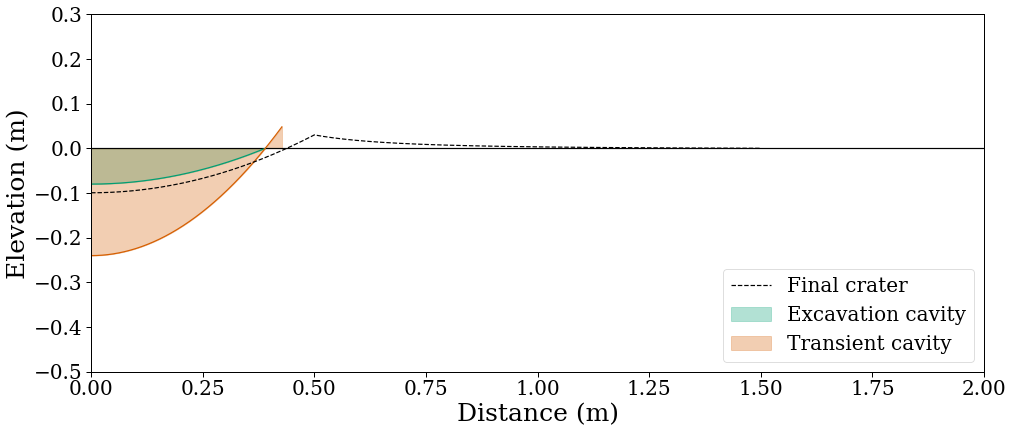

In [40]:
# Model geometry
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111)
plt.plot(dist, surface, c='k')


# Excavation cavity
plt.plot(dist_excav, elev_excav, c=color_arr[1])
plt.fill_between(dist_excav, np.zeros(len(elev_excav)), elev_excav, color=color_arr[1], alpha=0.3, label='Excavation cavity')

# Transient cavity
plt.plot(dist_tr, elev_tr, c=color_arr[2])
plt.fill_between(dist_tr, np.zeros(len(elev_tr)), elev_tr, color=color_arr[2], alpha=0.3, label='Transient cavity')

# Overplot final crater profile
plt.plot(dist_crater, elev_crater, c='k', alpha=1.0, ls='--', label='Final crater')

plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)

plt.xlabel('Distance (m)', fontsize=25)
plt.ylabel('Elevation (m)', fontsize=25)
plt.legend(loc='lower right', fontsize=20)
ax.tick_params('both', labelsize=20)
ax.set_aspect('equal')

plt.show()

# Fate of particles in the excavation cavity
Particles that are ejected are assumed to be launched outside the final crater interior. Flight distance is a function of the particle's distance from the impact point (0,0) such that:     

- Particles right at the impact point land at the edge of the continuous ejecta blanket ($r_f$ = 3R from the center)
- Particles at the very edge of the excavation cavity land right on the rim ($r_f$ = R)    

Particles are placed randomly within the thickness of the ejecta blanket at their landing point 
Crater exterior elevation falls off as $(r/R)^{-3}$ plus a linear term that ensures elevation goes to 0 at the edge of the continuous ejecta blanket. Ejecta thickness is taken to be 1/3 of the total elevation of the crater profile at a given distance following conservation of volume (Maxwell (1977); Melosh (1989)).

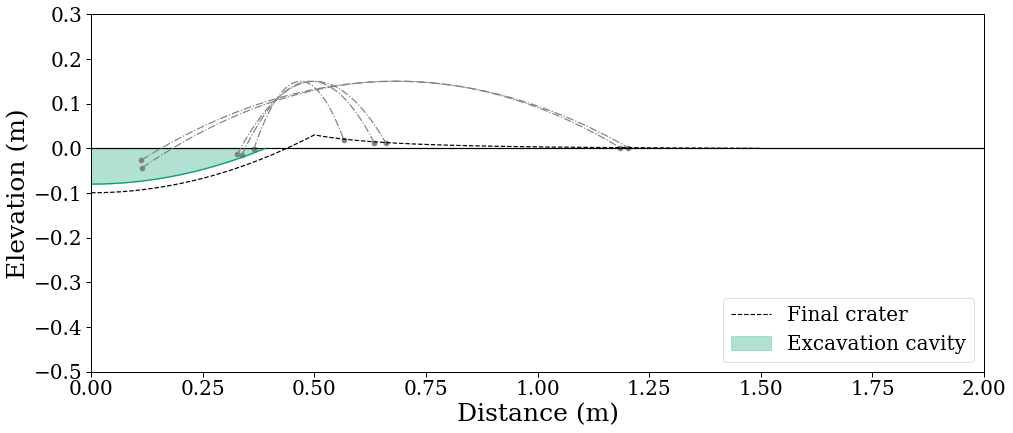

In [41]:
# Ejection
def func(x, a, b, c):
  return a*x**2 + b*x + c


# Initial positions of particles 
d_particles = np.random.uniform(0.0, crater_radius_excav, size=5)
z_excav = (((d_particles/crater_radius_excav)**2)*(rim_height_excav + depth_excav)) - depth_excav
depth_particles = np.array([np.random.uniform(0.0, z_excav[i]) for i in range(len(d_particles))])
r0_particles = np.sqrt(d_particles**2 + depth_particles**2)

# Landing position of particles and crater elevation/ejecta thickness there
r_f_particles = (3.0*crater_radius) - (2.0*crater_radius)*(r0_particles/crater_radius_excav)
z_crater = rim_height*((r_f_particles/crater_radius)**-3) - (rim_height/54.0)*((r_f_particles/crater_radius) - 1.0)
ejecta_thickness = (1.0/3.0)*rim_height*((r_f_particles/crater_radius)**-3) - (rim_height/54.0)*((r_f_particles/crater_radius) - 1.0)
depth_particles_final = [z_crater[i] - np.random.uniform(0.0, ejecta_thickness[i]) for i in range(len(d_particles))]


fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111)
plt.plot(dist, surface, c='k')

# Excavation cavity
plt.plot(dist_excav, elev_excav, c=color_arr[1])
plt.fill_between(dist_excav, np.zeros(len(elev_excav)), elev_excav, color=color_arr[1], alpha=0.3, label='Excavation cavity')


# Plot random particle positions within the excavation volume
for i in range(len(d_particles)):
    plt.scatter(d_particles[i], depth_particles[i], c='gray')
    plt.scatter(r_f_particles[i], depth_particles_final[i], c='gray')
    
    x0, y0 = d_particles[i], depth_particles[i]
    xf, yf = r_f_particles[i], depth_particles_final[i]
    
    vertex = (1.0*np.sin(np.deg2rad(45.0)))**2/(2.0*1.67)
    
    x = [x0, x0 + (xf-x0)/2.0, xf]
    y = [y0, vertex, yf]
    
    popt, _ = curve_fit(func, x, y, bounds=([-np.inf, -np.inf, -np.inf], [0.0, np.inf, np.inf]))

    xnew = np.linspace(x[0], x[-1], 100)

    plt.plot(xnew, func(xnew, *popt), 'gray', ls='-.')

    # (Particle trajectories are for instructive purposes only.)
    
    
# Overplot final crater profile
plt.plot(dist_crater, elev_crater, c='k', alpha=1.0, ls='--', label='Final crater')


plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)

plt.xlabel('Distance (m)', fontsize=25)
plt.ylabel('Elevation (m)', fontsize=25)
plt.legend(loc='lower right', fontsize=20)
ax.set_aspect('equal')
ax.tick_params('both', labelsize=20)
ax.set_aspect('equal')

plt.show()

# Fate of particles inside the transient cavity 

Particles that are transported by the crater flow field form the transient cavity. They are transported radially through the subsurface following the Maxwell Z-model with Z=2 (a simplification). The radial distance each particle travels is $(d_{tr} - d_{excav})cos(\theta)$, where theta is the angle between the particle's initial and the vertical. This equation dictates that particles just below the center of the excavation cavity are pushed down to the bottom of the transient crater. Particles deeper than this are pushed into the subsurface below the deepest extent of the transient cavity. Particles on the periphery of the transient bowl, distant from the impact site, are not transported very far.

Once the flow field has ceased, one of two things can happen to a particle.   

1. If the particle has not been pushed below or outside the transient cavity, it ends up being part of the volume of material that collapses to form the final crater. These particles are placed randomly within the thickness of the breccia lens. Infilling particles are assigned a new position sampled uniformly random between their post-flow position and the center of the final crater. Their final depth is then sampled uniformly random between the transient and final crater elevation at that point.

2. Particles that flow beyond the extent of the transient cavity remain there after crater collapse. Their final depth is calculated taking into account the elevation change at their position due to the newly formed crater.

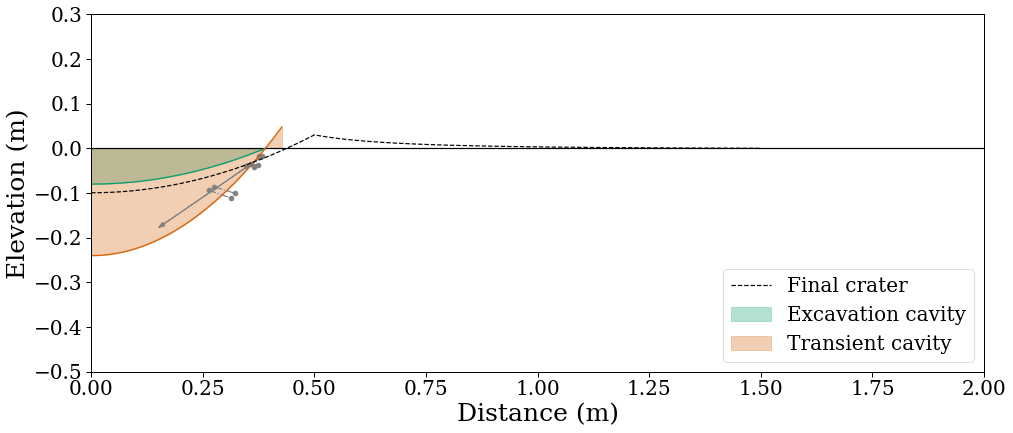

In [42]:
# Subsurface transport 


d_particles = np.random.uniform(0.0, 0.9*crater_radius_tr, size=5)
z_tr = (((d_particles/crater_radius_tr)**2)*(rim_height_tr + depth_tr)) - depth_tr
z_excav = (((d_particles/crater_radius_tr)**2)*(rim_height_excav + depth_excav)) - depth_excav

depth_particles = np.array([np.random.uniform(z_excav[i], z_tr[i]) for i in range(len(d_particles))])

r0_particles = np.sqrt(d_particles**2 + abs(depth_particles)**2)
theta0_particles = np.arctan(d_particles/abs(depth_particles))
    
# Subsurface flow 
r_flow_particles = (depth_tr - depth_excav)*np.cos(theta0_particles)
r_new_particles = r0_particles + r_flow_particles


d_particles_new = r_new_particles*np.sin(theta0_particles)
depth_particles_new = -1.0*r_new_particles*np.cos(theta0_particles)

fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111)
plt.plot(dist, surface, c='k')


# Excavation cavity
plt.plot(dist_excav, elev_excav, c=color_arr[1])
plt.fill_between(dist_excav, np.zeros(len(elev_excav)), elev_excav, color=color_arr[1], alpha=0.3, label='Excavation cavity')

# Transient cavity
plt.plot(dist_tr, elev_tr, c=color_arr[2])
plt.fill_between(dist_tr, np.zeros(len(elev_tr)), elev_tr, color=color_arr[2], alpha=0.3, label='Transient cavity')


for i in range(len(d_particles)):
    plt.scatter(d_particles[i], depth_particles[i], c='gray')
    plt.scatter(d_particles_new[i], depth_particles_new[i], c='gray')
    plt.plot([d_particles[i], d_particles_new[i]], [depth_particles[i], depth_particles_new[i]], c='gray', ls='-.')

    depth_tr_point_new = abs((((d_particles_new[i]/crater_radius_tr)**2)*(rim_height_tr + depth_tr)) - depth_tr)

    if d_particles_new[i] <= crater_radius_tr and abs(depth_particles_new[i]) <= abs(depth_tr_point_new):
        # Infilling
        R_final = np.random.uniform(0.0, d_particles_new[i])

        depth_tr_point_final = abs((((R_final/crater_radius_tr)**2)*(rim_height_tr + depth_tr)) - depth_tr)
        depth_crater_point_final = abs((((R_final/crater_radius)**2)*(rim_height + depth)) - depth)

        breccia_thickness = depth_tr_point_final - depth_crater_point_final
        particle_depth_final = np.random.uniform(0.0, breccia_thickness)
        
        depth_final = -depth_crater_point_final - particle_depth_final
        
        
        plt.arrow(d_particles_new[i], depth_particles_new[i], R_final-d_particles_new[i], depth_final - depth_particles_new[i], color='gray', head_width=0.01)

        

    depth_crater_point_final = abs((((d_particles_new[i]/crater_radius)**2)*(rim_height + depth)) - depth)

    if abs(depth_particles_new[i]) <= depth_crater_point_final:
        R_final = np.random.uniform(0.0, d_particles_new[i])

        depth_tr_point_final = abs((((R_final/crater_radius_tr)**2)*(rim_height_tr + depth_tr)) - depth_tr)
        depth_crater_point_final = abs((((R_final/crater_radius)**2)*(rim_height + depth)) - depth)

        breccia_thickness = depth_tr_point_final - depth_crater_point_final
        particle_depth_final = np.random.uniform(0.0, breccia_thickness)
        
        depth_final = -depth_crater_point_final - particle_depth_final
        
        plt.arrow(d_particles_new[i], depth_particles_new[i], R_final-d_particles_new[i], depth_final - depth_particles_new[i], color='gray', head_width=0.01)

        
# Overplot final crater profile
plt.plot(dist_crater, elev_crater, c='k', alpha=1.0, ls='--', label='Final crater')



plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)

plt.xlabel('Distance (m)', fontsize=25)
plt.ylabel('Elevation (m)', fontsize=25)
plt.legend(loc='lower right', fontsize=20)
ax.set_aspect('equal')
ax.tick_params('both', labelsize=20)
ax.set_aspect('equal')

plt.show()

# Fate of particles outside the transient cavity

Particles outside the flow field region are not directly moved by the crater's formation.
However, their depth relative to the surface can still change as material is removed or added in the column above them during the excavation and modification process.    

- Particles outside the flow region that are under the final crater bowl will end up closer to the surface since material is excavated from above them
- Particles outside the flow region that are under the ejecta blanket will become deeper as material is either displaced and uplifted or deposited as ejecta


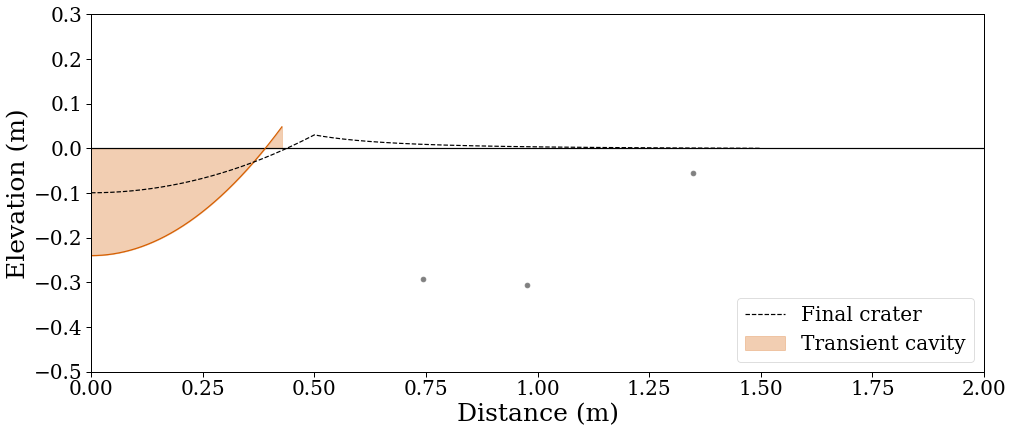

In [44]:
# Burial/shallowing
d_particles = np.random.uniform(0.0, 3.0*crater_radius, size=5)
depth_particles = np.zeros(len(d_particles))
z_tr = (((d_particles/crater_radius_tr)**2)*(rim_height_tr + depth_tr)) - depth_tr

for i in range(len(d_particles)):
    
    if d_particles[i] <= crater_radius_tr:
        
        depth_particles[i] = np.random.uniform(z_tr[i], -1.0)
    else:
        depth_particles[i] = np.random.uniform(0.0, -0.4)
        
        

fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111)
plt.plot(dist, surface, c='k')


# Transient cavity
plt.plot(dist_tr, elev_tr, c=color_arr[2])
plt.fill_between(dist_tr, np.zeros(len(elev_tr)), elev_tr, color=color_arr[2], alpha=0.3, label='Transient cavity')


# Plot particle positions
plt.scatter(d_particles, depth_particles, c='gray')


# Overplot final crater profile
plt.plot(dist_crater, elev_crater, c='k', alpha=1.0, ls='--', label='Final crater')


plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)

plt.xlabel('Distance (m)', fontsize=25)
plt.ylabel('Elevation (m)', fontsize=25)
plt.legend(loc='lower right', fontsize=20)
ax.tick_params('both', labelsize=20)
ax.set_aspect('equal')
plt.show()

# Putting it all together

With this framework for how the formation of small impact craters excavates, transports, and buries regolith, we are equipped to evaluate the surface residence time of synthetic regolith tracer particles. Our landscape evolution model stores each particle's average depth at every 1 Myr timestep over the course of a 3.48 Gyr run. Our Monte Carlo regolith mixing model is applied to the output of this model to understand how particles' depths change due to small impacts.    
- Craters forming during a timestep within the scale of a single pixel are randomly sampled from the appropriate impact flux (a combination of primary and secondary impacts).   

- Changes in particles' depth relative to the surface as a result of the crater's formation are calculated as outlined above. During the 1 Myr, craters are assumed to occur evenly spaced in time such that the time between impacts is simply $\frac{1 Myr}{N_{craters}}$ (As it turns out, $N_{craters}$ is close to $10^4$ meaning that the average time between events is roughly 100 years).    

- Finally, the time series of particles' depths at each sub-timestep, aka the "stock market curve" (Arnold, 1975), are used to assess time spent at a depth of 1 mm or less where they would be exposed to the effects of space weathering (Morris, 1978).

In [45]:
class Model:
    def __init__(self):
        pass

    def setup(self, dt):
        D_min = 0.01    # m
        D_max = 8.0     # m

        diam_bins = [D_min]
        while diam_bins[-1] < D_max:
            diam_bins.append(np.sqrt(2.0)*diam_bins[-1])
        diam_bins = np.array(diam_bins)

        # Incremental number of craters per km^2 per year (combined primary
        # and secondary fluxes)
        N_inc = (2.15e-3)*(diam_bins**-3.13) + (4.6e-2)*(diam_bins**-4.06)

        area_arr = np.zeros(len(diam_bins))
        for i in range(len(diam_bins)):
            radius = (3.0/2.0)*diam_bins[i]

            area_arr[i] = np.pi*(radius**2)/(1.e6) 	# km^2

        num_inc_craters = N_inc*area_arr*dt

        average_crater_diam = 0.5*(1.0 + np.sqrt(2.0))*diam_bins

        self.average_crater_diam = average_crater_diam
        self.N_inc = N_inc
        self.num_inc_craters = num_inc_craters
        self.D_max = D_max
        self.dt = dt
        self.d_surface = 0.01



    def sampleEvents(self):
        craters = np.random.poisson(lam=self.num_inc_craters)

        crater_diams = []

        for i in range(len(self.average_crater_diam)):
            crater_diams.append(self.average_crater_diam[i]*np.ones(craters[i]))
        crater_diams = np.concatenate(np.array(crater_diams))

        np.random.shuffle(crater_diams)

        crater_dists = (3.0/2.0)*crater_diams*np.sqrt(np.random.uniform(size=len(crater_diams)))

        return crater_diams, crater_dists
    
    
    def randomWalk(self, d0, crater_diams, crater_dists):

        timestep_depth_arr = [d0]
        
        delta_h_arr = np.zeros(len(crater_diams))
        h_arr = np.zeros(len(crater_diams))
     
        for i in range(len(crater_diams)):
            crater_radius = crater_diams[i]/2.0
            crater_radius_tr = crater_radius/1.17 

            size_index = 0.75
            depth = (269.0/81.0)*(0.04*crater_diams[i])*size_index
            rim_height = 0.04*crater_diams[i]*size_index

            depth_excav = 0.125*(2.0*crater_radius_tr)*size_index
            depth_tr = (3.0/8.0)*(2.0*crater_radius_tr)*size_index
            rim_height_tr = 0.2*(3.0/8.0)*(2.0*crater_radius_tr)*size_index
            
            
            crater_radius_excav = crater_radius_tr*np.sqrt(depth_tr/(depth_tr + rim_height_tr))
            rim_height_excav = 0.0
            
            r0 = np.sqrt(crater_dists[i]**2 + timestep_depth_arr[-1]**2)
            theta0 = np.arctan(crater_dists[i]/timestep_depth_arr[-1])
            

            if crater_dists[i] <= crater_radius:
                depth_excav_point = abs((((crater_dists[i]/crater_radius_excav)**2)*(rim_height_excav + depth_excav)) - depth_excav)
                depth_tr_point = abs((((crater_dists[i]/crater_radius_tr)**2)*(rim_height_tr + depth_tr)) - depth_tr)
                
                if crater_dists[i] <= crater_radius_tr and timestep_depth_arr[-1] <= depth_excav_point:
                    # Ejected
                    
                    r_f = 3.0*crater_radius - 2.0*crater_radius*(r0/crater_radius_tr)
                    ejecta_thickness = (1.0/3.0)*rim_height*((r_f/crater_radius)**-3) - (rim_height/54.0)*((r_f/crater_radius) - 1.0)
                    
                    particle_depth_final = np.random.uniform(0.0, ejecta_thickness)
                    
                elif crater_dists[i] <= crater_radius_tr and timestep_depth_arr[-1] <= depth_tr_point:
                    
                    # Subsurface flow 
                    r_flow = (depth_tr - depth_excav)*np.cos(theta0)
                    r_new = r0 + r_flow
                    
                    crater_dist_new = r_new*np.sin(theta0)
                    particle_depth_new = r_new*np.cos(theta0)
                    
                    depth_tr_point_new = abs((((crater_dist_new/crater_radius_tr)**2)*(rim_height_tr + depth_tr)) - depth_tr)
            
                    if crater_dist_new <= crater_radius_tr and particle_depth_new <= depth_tr_point_new:
                        # Infilling
                        R_final = np.random.uniform(0.0, crater_dist_new)
                        
                        depth_tr_point_final = abs((((R_final/crater_radius_tr)**2)*(rim_height_tr + depth_tr)) - depth_tr)
                        depth_crater_point_final = abs((((R_final/crater_radius)**2)*(rim_height + depth)) - depth)
                        
                        breccia_thickness = depth_tr_point_final - depth_crater_point_final
                        particle_depth_final = np.random.uniform(0.0, breccia_thickness)
                        
                    else:
                    
                        # End in subsurface 
                        if crater_dist_new <= crater_radius:
                            delta_h_crater = (((crater_dist_new/crater_radius)**2)*(rim_height + depth)) - depth
                        
                            if particle_depth_new + delta_h_crater < 0.0:
                                # Infilling (v2)
                                
                                R_final = np.random.uniform(0.0, crater_dist_new)
                        
                                depth_tr_point_final = abs((((R_final/crater_radius_tr)**2)*(rim_height_tr + depth_tr)) - depth_tr)
                                depth_crater_point_final = abs((((R_final/crater_radius)**2)*(rim_height + depth)) - depth)

                                breccia_thickness = depth_tr_point_final - depth_crater_point_final
                                particle_depth_final = np.random.uniform(0.0, breccia_thickness)
                                
                            else:
                                particle_depth_final = particle_depth_new + delta_h_crater
                        
                                
                        elif crater_radius < crater_dist_new <= 3.0*crater_radius:
                            delta_h_crater = rim_height*((crater_dist_new/crater_radius)**-3) - (rim_height/54.0)*((crater_dist_new/crater_radius) - 1.0)

                            particle_depth_final = particle_depth_new + delta_h_crater
                        
                else:
                    # Unaffected
                    delta_h_crater = (((crater_dists[i]/crater_radius)**2)*(rim_height + depth)) - depth

                    particle_depth_final = timestep_depth_arr[-1] + delta_h_crater


            elif crater_radius < crater_dists[i] <= 3.0*crater_radius:
                # Unaffected 
                delta_h_crater = rim_height*((crater_dists[i]/crater_radius)**-3) - (rim_height/54.0)*((crater_dists[i]/crater_radius) - 1.0)

                particle_depth_final = timestep_depth_arr[-1] + delta_h_crater
                
            if particle_depth_final < 0.0:
                particle_depth_final = 0.0

            timestep_depth_arr.append(particle_depth_final)

        # Return the array of depths for the entire timestep
        timestep_depth_arr = np.array(timestep_depth_arr)
        timestep_depth_arr[-1] = d0
        
        return timestep_depth_arr
    
    
    def plot_depth(self, timestep_depth_arr):

        time_arr = np.linspace(0.0, self.dt, len(timestep_depth_arr))
        fig = plt.figure(figsize=(16,8))
        ax = fig.add_subplot(111)
        plt.plot(time_arr/(1.e6), timestep_depth_arr, marker='o', color=color_arr[0], markersize=3)
        plt.axvline(0.0, c='k')
        plt.axvline(self.dt/(1.e6), c='k')
        plt.axhline(0.0, c='k')
        plt.axhline(self.d_surface, c='k', ls='--')
        plt.gca().invert_yaxis()
        plt.xlabel('Time (Myr)', fontsize=25)
        plt.ylabel('Depth (m)', fontsize=25)
        ax.tick_params('both', labelsize=20)

        plt.show()

# Model flux

Costello et al. (2018) concluded that secondaries dominate mixing in the upper meter of the lunar regolith. For completeness, the impact flux that drives gardening in our model is a combination of primary and secondary impacts. The flux shown below is derived from that in our macroscopic landscape evolution model and extrapolated to sizes relevant for craters forming on the sub-pixel scale. This, coupled with the size bounds of craters considered in our mixing model, ensures continuity of crater formation across all spatial scales.    

The smallest crater considered here is 1 cm. Craters smaller than this induce elevation changes on the order of millimeters and enter in the regime where impactors are effectively striking rock as the impactor size approaches that of individual regolith grains. The largest crater has a diameter of 2 times the macroscopic model pixel scale (in this case 8 meters). This is the smallest resolved crater in the landscape evolution model.    

This flux is used to randomly sample all the small craters that form during a given timestep (1 Myr) that might alter the depth of a synthetic regolith tracer particle. For each crater size bin, we define a circular area in which a crater of that size could form and lead to a non-zero elevation change at the distance of the particle. In the plot below, the particle is assumed to be at the origin (0,0). The size of each dot corresponds to the crater diameter, showing that larger craters can form at relatively larger distances and still influence the particle's depth.


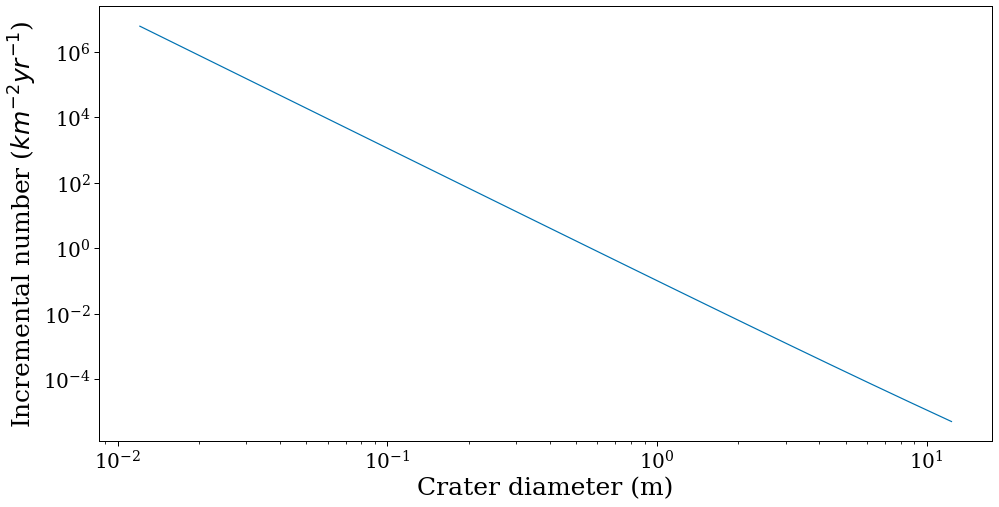

In [47]:
# Crater flux
dt = 1.e6
model = Model()
model.setup(dt)


fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(111)
plt.loglog(model.average_crater_diam, model.N_inc, c=color_arr[0])
plt.xlabel('Crater diameter (m)', fontsize=25)
plt.ylabel('Incremental number ($km^{-2} yr^{-1}$)', fontsize=25)
ax.tick_params('both', labelsize=20)
plt.show()

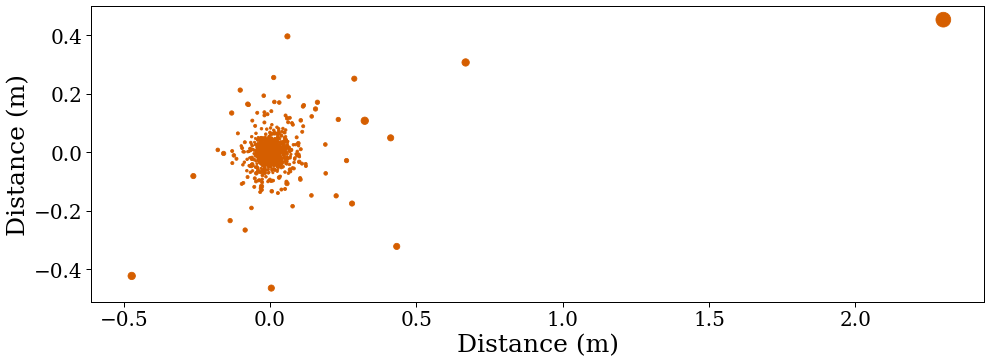

In [61]:
# Crater sampling area 

model = Model()
model.setup(dt)

crater_diams, crater_dists = model.sampleEvents()
crater_thetas = np.random.uniform(0.0, 2.0*np.pi, size=len(crater_diams))

crater_x = crater_dists*np.cos(crater_thetas)
crater_y = crater_dists*np.sin(crater_thetas)

fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(111)
plt.scatter(crater_x, crater_y, c=color_arr[2], s=100*crater_diams)
plt.xlabel('Distance (m)', fontsize=25)
plt.ylabel('Distance (m)', fontsize=25)
ax.tick_params('both', labelsize=20)
ax.set_aspect('equal')
plt.show()

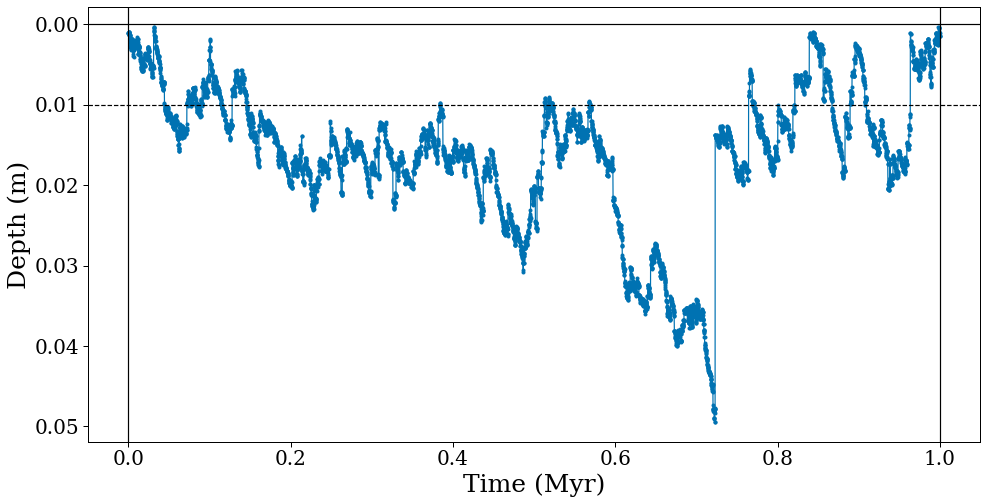

In [54]:
# Depth vs. time
dt = 1.e6
d0 = 0.001
model = Model()
model.setup(dt)

crater_diams, crater_dists = model.sampleEvents()
timestep_depth_arr = model.randomWalk(d0, crater_diams, crater_dists)

model.plot_depth(timestep_depth_arr)